# SAP HANA CLOUD SPATIAL DATA SCIENCE 

In the field of Data Science, spatial data gets more and more relevant. Thus, (Geo-)Spatial Data Science or Advanced (Geo-)Spatial Analytics is expected to be one of the trending topics. Due to its seamless integration of multi-model data with embedded machine learning, SAP HANA is the platform of choice for this evolving discipline.


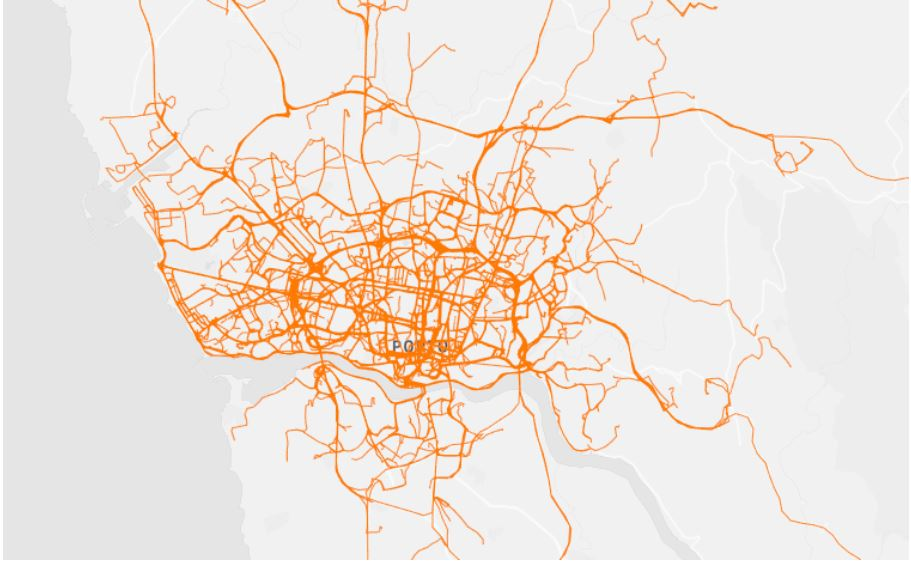

https://blogs.sap.com/2020/02/08/spatial-data-science-powered-by-sap-hana/ 

# Technology Stack

Technology setup for this HANA cloud Technical Academy Session

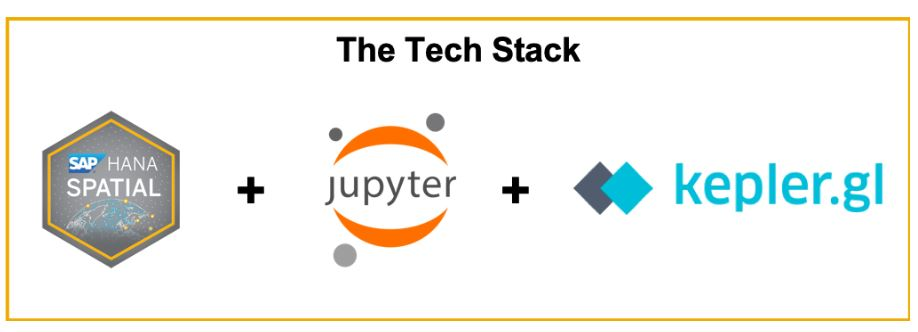

# Dataset 

We will use Kaggle's Taxi Trajectory dataset which will be available in AWS S3 and accessed in SAP HANA using Athena Adapter.Participants will be used federated data access to this dataset.

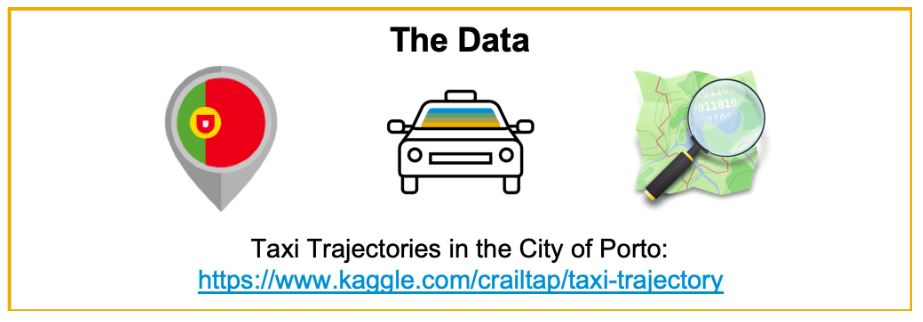

# Import HANA ML & open Source Python Libraries

In [ ]:
# dealing with datasets in Python
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt 

# db connectivity
import sqlalchemy

# load osm data
import osmnx as ox

# visualization of spatial data
from keplergl import KeplerGl
from shapely import wkt

# embedded ML and visualization of model charts
from hana_ml import dataframe
from hana_ml.algorithms.apl import regression
from matplotlib import pyplot



# Create HANA Cloud Database Connection 

In [ ]:
# Database connection details
hdb_host = 'e010f27e-a99e-4463-bbc4-a412c861de03.hana.prod-eu10.hanacloud.ondemand.com'
hdb_port = 443
hdb_user = 'HC_DEV'
hdb_password = 'Welcome01'

hdb_schema = 'HC_DEV'

connection_string = 'hana://%s:%s@%s:%s' % (hdb_user, hdb_password, hdb_host, hdb_port)

In [ ]:
# Enable inline SQL for readability
%reload_ext sql
%config SqlMagic.displaylimit = 100
%sql $connection_string
%sql SET SCHEMA $hdb_schema

### Use HANA ML Remote Dataframe  (Data is not loaded in python session)

In [ ]:
import hana_ml.dataframe as dataframe

# Instantiate connection object
conn = dataframe.ConnectionContext(address = 'e010f27e-a99e-4463-bbc4-a412c861de03.hana.prod-eu10.hanacloud.ondemand.com',
                                   port = 443, 
                                   user = 'HC_DEV',    ## HANA Cloud TA username 
                                   password = 'Welcome01', ## HANA Cloud TA username / Password
                                   encrypt = 'true',
                                   sslValidateCertificate = 'false' 
                                  )

# Send basic SELECT statement and display the result
sql = 'SELECT 12345 FROM DUMMY'
df_remote = conn.sql(sql)
print(df_remote.collect())

In [ ]:
hdb_connection = sqlalchemy.create_engine(connection_string).connect()

#obj_cols = df_csv.select_dtypes(include=[object]).columns.values.tolist()
#obj_cols.remove('POLYLINE')
#df_csv.to_sql(name = 'taxi1', schema=hdb_schema, con = hdb_connection, if_exists = 'replace', chunksize = 500, dtype={c: sqlalchemy.types.String(512) for c in obj_cols})

### Create a new Table in SAP HANA to load the Taxi Trajectory dataset in your local context 

In [ ]:
%sql CREATE COLUMN TABLE TAXI1 LIKE "HC_DEV"."TAXI_TR1" WITH DATA

In [ ]:
%sql SELECT COUNT(*) FROM TAXI1

# Create a CONVEX_HULL on the Point of Interest Data

In [ ]:
#Include Point of Interest Data
sql_result = %sql SELECT ST_CONVEXHULLAGGR(SHAPE).ST_TRANSFORM(4326).ST_ASWKT() FROM TAXI
df_poi_shape = sql_result.DataFrame()

In [ ]:
KeplerGl(height=500, data={'poi_shape':df_poi_shape})

In [ ]:
gdf_poi = ox.geometries.geometries_from_polygon(
    df_poi_shape[df_poi_shape.columns[0]].apply(wkt.loads).iloc[0], 
    tags={'amenity':True, 'landuse':['retail','commercial'], 'highway':'bus_stop'}
)
gdf_poi.shape

 Below is the expected Kepler GL output this is provided as a backup in case notebook execution runs into problems

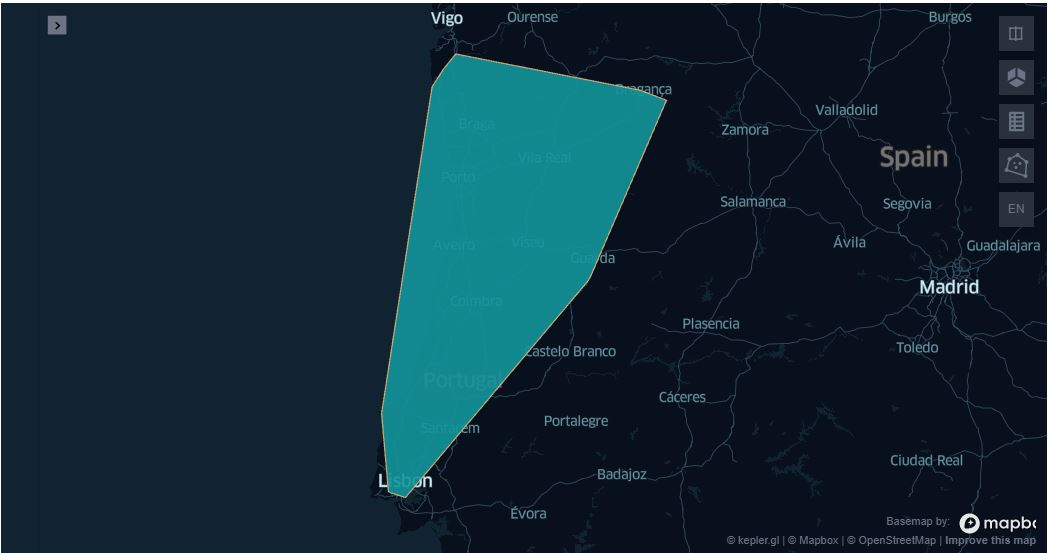

In [ ]:
# time taking ste

In [ ]:
%sql CREATE COLUMN TABLE osm_poi1 LIKE "HC_DEV".osm_poi WITH DATA

In [ ]:
df_poi = pd.DataFrame(gdf_poi)
df_poi.reset_index(inplace=True)
df_poi = df_poi[['osmid', 'geometry', 'amenity', 'name']]
df_poi["geometry"] = df_poi["geometry"].astype("str")
df_poi = df_poi.infer_objects()

In [ ]:

# remve belw scell

In [ ]:
hdb_connection = sqlalchemy.create_engine(connection_string).connect()
obj_cols = df_poi.select_dtypes(include=[object]).columns.values.tolist()
obj_cols.remove('geometry')
df_poi.to_sql(name = 'osm_poi1', schema=hdb_schema, con = hdb_connection, if_exists = 'replace', chunksize = 100, dtype={c:sqlalchemy.types.String(512) for c in obj_cols})

In [ ]:
%%sql sql_result <<
SELECT 
    HEXID, 
    HEXCENTROID.ST_TRANSFORM(4326).ST_ASWKT() AS HEXCENTROID,
    HEXCELL.ST_TRANSFORM(4326).ST_ASWKT() AS HEXCELL
FROM REFGRID

In [ ]:
df_refgrid = sql_result.DataFrame()

In [ ]:
df_poi.reset_index(inplace=True)

In [ ]:
KeplerGl(height=500, data={'refgrid':df_refgrid, 'poi_shape':df_poi_shape})

 Below is the expected Kepler GL output this is provided as a backup in case notebook execution runs into problems

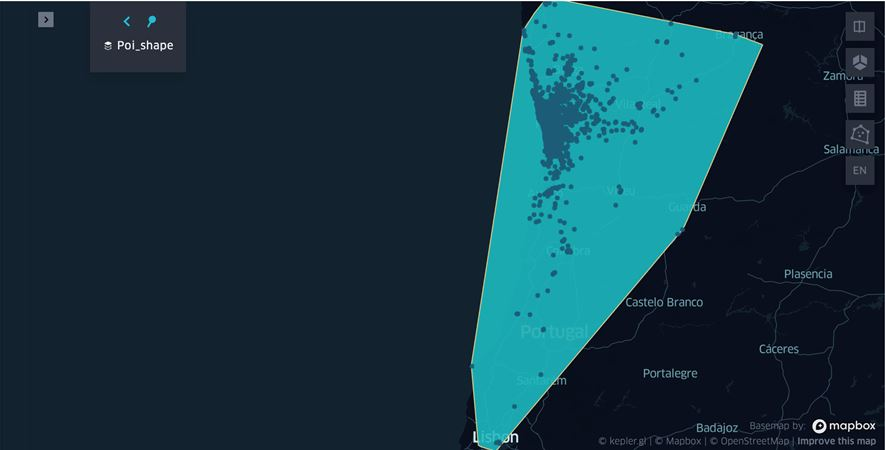

In [ ]:
%sql SELECT AVG(DISTANCE)/1000 AS DISTANCE_KM FROM TAXI1

In [ ]:
%sql SELECT AVG(DURATION)/60 AS DURATION_MINUTES FROM TAXI1

In [ ]:
%sql SELECT AVG(SPEED_AVG) AS SPEED_KMH FROM TAXI1

In [ ]:
%%sql sql_result << 
SELECT TOP 1000
    INDEX, 
    TRIP_ID, 
    CALL_TYPE, 
    TAXI_ID, 
    STARTTIME, 
    ENDTIME,
    SPEED_AVG,
    SHAPE.ST_TRANSFORM(4326).ST_ASWKT() as SHAPE
FROM TAXI1
ORDER BY RAND()

In [ ]:
df_sample_trajectories = sql_result.DataFrame()

In [ ]:
map_sample_config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 41.16064263660347,
            'longitude': -8.61937846161915,
            'zoom': 10.936755405111594
        }
    }
}

KeplerGl(height=500, data={'samples':df_sample_trajectories}, config=map_sample_config)

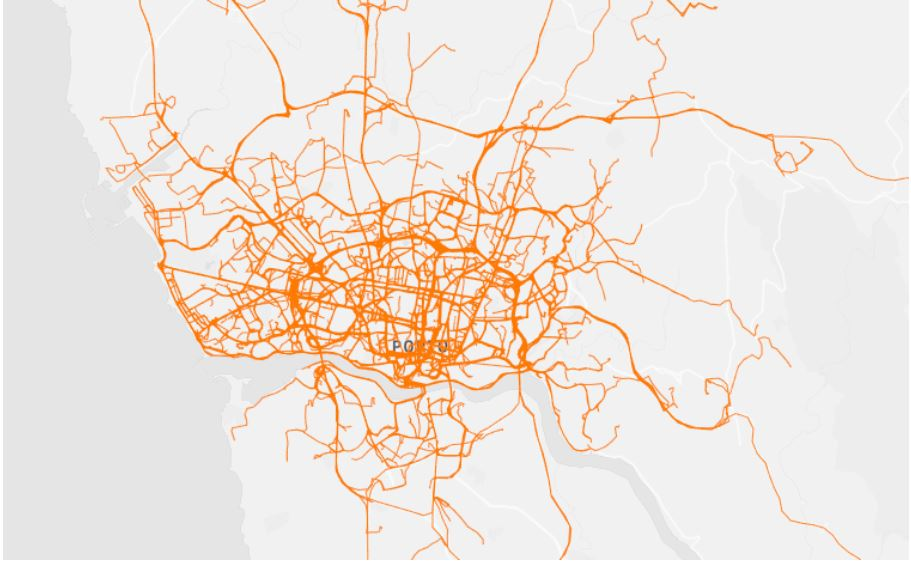

In [ ]:
sql_result = %sql SELECT OSMID, SHAPE.ST_TRANSFORM(4326).ST_ASWKT() AS SHAPE, AMENITY, NAME FROM OSM_POI1
df_all_poi = sql_result.DataFrame()

In [ ]:
KeplerGl(height=500, data={'pois':df_all_poi, 'samples':df_sample_trajectories}, config=map_sample_config)

# POIs in the Cluster Cells with Most Pick-ups

In [ ]:
%%sql sql_result <<
SELECT B.OSMID, B.SHAPE.ST_TRANSFORM(4326).ST_ASWKT() AS OSMSHAPE, B.AMENITY, B.NAME, A.HEXCELL.ST_TRANSFORM(4326).ST_ASWKT() AS HEXSHAPE
FROM 
(
    SELECT TOP 3 ST_CLUSTERCELL() AS HEXCELL
    FROM TAXI1
    GROUP CLUSTER BY STARTPOINT USING HEXAGON X CELLS 500
    ORDER BY COUNT(*) DESC
) A LEFT JOIN OSM_POI1 B ON A.HEXCELL.ST_INTERSECTS(B.SHAPE) = 1

In [ ]:
df_top_cells = sql_result.DataFrame()

In [ ]:
map_top_cells_config = {
    'version': 'v1',
    'config': {
        'mapState': {
           'latitude': 41.14581779896211,
           'longitude': -8.598703907021486,
           'zoom': 13.933597056454914
        }
    }
}

KeplerGl(height=500, data={'top_cells':df_top_cells}, config=map_top_cells_config)
#POIs in the Cluster Cells with Most Pick-ups


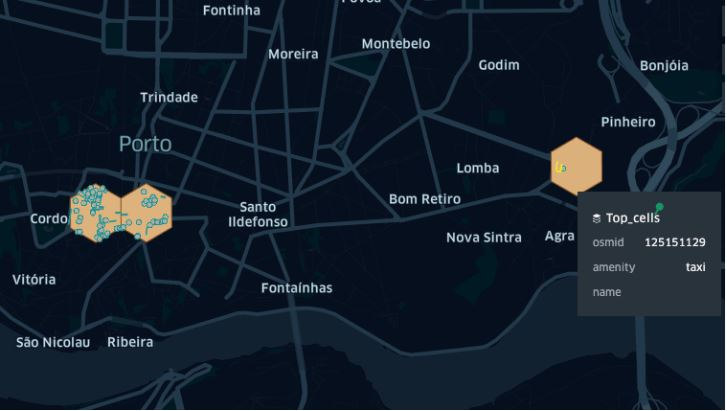

# Pick-up Locations Over Time

In [ ]:
%%sql sql_result <<
SELECT 
    CLUSTERID, 
    CLUSTERCELL.ST_TRANSFORM(4326).ST_ASGEOJSON() AS CLUSTERCELL, 
    HOURBIN,
    LOG(10, COUNT(*)) AS QUANTITY
FROM
(
    SELECT 
        TO_TIMESTAMP(YEAR(STARTTIME) || '-' || MONTH(STARTTIME) || '-' || DAYOFMONTH(STARTTIME) || ' ' || LPAD(HOUR(STARTTIME) - MOD(HOUR(STARTTIME),2), 2, '0') || ':00:00') AS HOURBIN,
        ST_CLUSTERID() OVER (CLUSTER BY STARTPOINT USING HEXAGON X CELLS 250) AS CLUSTERID,
        ST_CLUSTERCELL() OVER (CLUSTER BY STARTPOINT USING HEXAGON X CELLS 250) AS CLUSTERCELL,
        TRIP_ID
    FROM TAXI1
)
GROUP BY CLUSTERID, CLUSTERCELL, HOURBIN
HAVING COUNT(*) > 1

In [ ]:
df_pickup_time = sql_result.DataFrame()


In [ ]:
map_pickup_time_config = {'version': 'v1',
 'config': {'visState': {'filters': [{'dataId': 'timebins',
     'id': '2clyivov',
     'name': 'hourbin',
     'type': 'timeRange',
     'value': [1385856000000, 1385863200000],
     'enlarged': True,
     'plotType': 'histogram',
     'yAxis': None}],
   'layers': [{'id': 'nngj5g8j',
     'type': 'geojson',
     'config': {'dataId': 'timebins',
      'label': 'timebins',
      'color': [248, 149, 112],
      'columns': {'geojson': 'clustercell'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [130, 154, 227],
       'colorRange': {'name': 'Uber Viz Diverging 1.5',
        'type': 'diverging',
        'category': 'Uber',
        'colors': ['#00939C',
         '#5DBABF',
         '#BAE1E2',
         '#F8C0AA',
         '#DD7755',
         '#C22E00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': True,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'quantity', 'type': 'real'},
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': {'name': 'quantity', 'type': 'real'},
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'timebins': ['clusterid',
       'hourbin',
       'numberbin',
       'quantity']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 112.9908256880734,
   'dragRotate': True,
   'latitude': 41.20398275560239,
   'longitude': -8.67967113104948,
   'pitch': 52.77444039813042,
   'zoom': 10.424667679276855,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

In [ ]:
KeplerGl(height=700, data={'timebins':df_pickup_time}, config=map_pickup_time_config)


# The Route to the Airport

In [ ]:
%%sql sql_result <<
SELECT 
        START_HEXID,
        START_CENTROID.ST_TRANSFORM(4326).ST_X() AS START_CELL_LON,
        START_CENTROID.ST_TRANSFORM(4326).ST_Y() AS START_CELL_LAT,
        END_HEXID,
        END_CENTROID.ST_TRANSFORM(4326).ST_X() AS END_CELL_LON,
        END_CENTROID.ST_TRANSFORM(4326).ST_Y() AS END_CELL_LAT,
        COUNT(*) AS CNT
FROM 
(
    SELECT 
        TRIP_ID, 
        a.HEXID AS START_HEXID,
        a.HEXCENTROID AS START_CENTROID,
        b.HEXID AS END_HEXID,
        b.HEXCENTROID AS END_CENTROID
    FROM TAXI1
    LEFT JOIN REFGRID a ON STARTPOINT.ST_WITHIN(a.HEXCELL) = 1
    LEFT JOIN REFGRID b ON ENDPOINT.ST_WITHIN(b.HEXCELL) = 1
)
GROUP BY START_HEXID, START_CENTROID, END_HEXID, END_CENTROID
HAVING COUNT(*) > 100

In [ ]:
df_cell_relation = sql_result.DataFrame()


In [ ]:
config_cell_relation = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'j9i3lca',
     'type': 'arc',
     'config': {'dataId': 'cell relation',
      'label': 'cell relation',
      'color': [207, 237, 181],
      'columns': {'lat0': 'start_cell_lat',
       'lng0': 'start_cell_lon',
       'lat1': 'end_cell_lat',
       'lng1': 'end_cell_lon'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 2,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'sizeRange': [0, 10],
       'targetColor': [245, 153, 153]},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': {'name': 'cnt', 'type': 'integer'},
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'cell relation': ['start_hexid',
       'cnt',
       'end_hexid']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 26.752293577981668,
   'dragRotate': True,
   'latitude': 41.1926903030073,
   'longitude': -8.61496918743284,
   'pitch': 57.99119946737215,
   'zoom': 11.287843857109973,
   'isSplit': False},
  'mapStyle': {'styleType': 'light',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

KeplerGl(height=500, data={'cell relation':df_cell_relation}, config=config_cell_relation)


 Below is the expected Kepler GL output this is provided as a backup in case notebook execution runs into problems

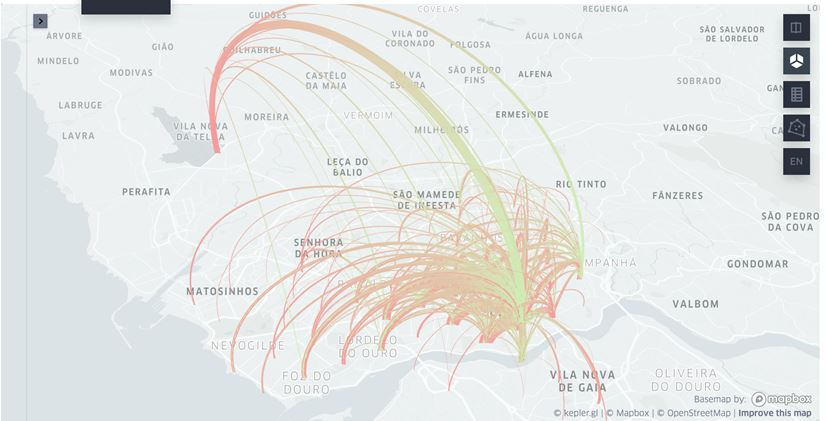

# What Is The Best Way From Sao Bento Station To The Airport?


In [ ]:
%%sql sql_result <<
SELECT
    INDEX, 
    TRIP_ID, 
    CALL_TYPE, 
    TAXI_ID, 
    STARTTIME, 
    ENDTIME,
    SPEED_AVG,
    DURATION,
    DISTANCE,
    SHAPE.ST_TRANSFORM(4326).ST_ASWKT() as SHAPE,
    a.HEXCELL.ST_TRANSFORM(4326).ST_ASWKT() AS START_HEXCELL,
    b.HEXCELL.ST_TRANSFORM(4326).ST_ASWKT() AS END_HEXCELL
FROM TAXI1 t
LEFT JOIN REFGRID a ON STARTPOINT.ST_WITHIN(a.HEXCELL) = 1
LEFT JOIN REFGRID b ON ENDPOINT.ST_WITHIN(b.HEXCELL) = 1
WHERE a.HEXID = 'HEXID-86826' AND b.HEXID = 'HEXID-90071' AND DISTANCE < 2 * a.HEXCENTROID.ST_DISTANCE(b.HEXCENTROID)

In [ ]:
df_frequent_route = sql_result.DataFrame()


In [ ]:
config_frequent_route = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': 'byb7s0c',
     'type': 'geojson',
     'config': {'dataId': 'frequent route',
      'label': 'frequent route',
      'color': [130, 154, 227],
      'columns': {'geojson': 'shape'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': None,
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Uber Viz Diverging 1.5',
        'type': 'diverging',
        'category': 'Uber',
        'colors': ['#00939C',
         '#5DBABF',
         '#BAE1E2',
         '#F8C0AA',
         '#DD7755',
         '#C22E00']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': False,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': {'name': 'duration', 'type': 'integer'},
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': '9phu6iq',
     'type': 'geojson',
     'config': {'dataId': 'frequent route',
      'label': 'frequent route',
      'color': [231, 159, 213],
      'columns': {'geojson': 'start_hexcell'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}},
    {'id': 'e7hwsd',
     'type': 'geojson',
     'config': {'dataId': 'frequent route',
      'label': 'frequent route',
      'color': [137, 218, 193],
      'columns': {'geojson': 'end_hexcell'},
      'isVisible': True,
      'visConfig': {'opacity': 0.8,
       'thickness': 0.5,
       'strokeColor': [179, 173, 158],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radius': 10,
       'sizeRange': [0, 10],
       'radiusRange': [0, 50],
       'heightRange': [0, 500],
       'elevationScale': 5,
       'stroked': True,
       'filled': True,
       'enable3d': False,
       'wireframe': False},
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'heightField': None,
      'heightScale': 'linear',
      'radiusField': None,
      'radiusScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'frequent route': ['index',
       'trip_id',
       'call_type',
       'taxi_id',
       'starttime']},
     'enabled': True},
    'brush': {'size': 0.5, 'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 41.190118850547385,
   'longitude': -8.63244718721786,
   'pitch': 0,
   'zoom': 11.044961898535204,
   'isSplit': False},
  'mapStyle': {'styleType': 'dark',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': True,
    'road': True,
    'border': False,
    'building': True,
    'water': True,
    'land': True,
    '3d building': False},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {}}}}

KeplerGl(height=500, data={'frequent route':df_frequent_route}, config=config_frequent_route)

# HANA Embedded Machine Learning

In [ ]:
from hana_ml import dataframe
from hana_ml.algorithms.apl import regression
from matplotlib import pyplot
from hana_ml.algorithms.apl import gradient_boosting_classification

In [ ]:
def performance_metrics_df(model):
    d = model.get_performance_metrics()
    df = pd.DataFrame(list(d.items()), columns=["Metric", "Value"])
    return df

In [ ]:
def plot_feature_importance(model):
    # retrieve importance as df
    d = model.get_feature_importances()
    df = pd.DataFrame(list(d.items()), columns=["Variable", "Contribution"])
    df['Contribution'] = df['Contribution'].astype(float)
    df['Cumulative'] = df['Contribution'].cumsum()
    df['Contribution'] = df['Contribution'].round(4)*100
    df['Cumulative'] = df['Cumulative'].round(4)*100
    non_zero = df['Contribution'] != 0
    dfs = df[non_zero].sort_values(by=['Contribution'], ascending=False)
    
    # visualize importance as bar chart
    c_title = "Contributions"
    dfs = dfs.sort_values(by=['Contribution'], ascending=True)
    dfs.plot(kind='barh', x='Variable', y='Contribution', title=c_title,legend=False, fontsize=12)
    pyplot.show()

In [ ]:
def plot_group_significance(model, feature):
    df = model.get_indicators().filter("VARIABLE='" + feature + "' and KEY='GroupSignificance'").collect()
    df['VALUE'] = df['VALUE'].astype(float)
    df.sort_values('VALUE', inplace = True, ascending = False)
    
    c_title = "Significance"
    df.plot(kind='barh', x='DETAIL', y='VALUE', title=c_title,legend=False, fontsize=12)
    pyplot.show()

In [ ]:
conn = dataframe.ConnectionContext(hdb_host, hdb_port, hdb_user, hdb_password)
conn.sql('SET SCHEMA %s' % (hdb_schema))

# Predict the duration of a trip

In [ ]:
hdf_trajectories = conn.sql('''
    SELECT
        INDEX,
        STARTTIME,
        R1.HEXID AS HEXID_START,
        R2.HEXID AS HEXID_END,
        DURATION
    FROM TAXI
    LEFT JOIN REFGRID R1 ON STARTPOINT.ST_WITHIN(R1.HEXCELL) = 1
    LEFT JOIN REFGRID R2 ON ENDPOINT.ST_WITHIN(R2.HEXCELL) = 1
''')

In [ ]:
regr_model = regression.AutoRegressor(conn_context = conn, variable_auto_selection = True)


In [ ]:
%%time
# Train model:
regr_model.fit(hdf_trajectories, label='DURATION', features=['STARTTIME', 'HEXID_START', 'HEXID_END'], key='INDEX')

# Load pre-trained model:
# regr_model.load_model(hdb_schema, 'MODEL_DURATION')
# regr_model.indicators_ = conn.sql('SELECT * FROM MODEL_DURATION_INDICATORS')

# Save model in HANA

In [ ]:
regr_model.save_artifact(regr_model.indicators_, hdb_schema, 'MODEL_DURATION_INDICATORS', if_exists='replace')
regr_model.save_model(hdb_schema, 'MODEL_DURATION', if_exists='replace')

In [ ]:
#Evaluate the model performance
performance_metrics_df(regr_model)

In [ ]:
#Analyze the variable importance

plot_feature_importance(regr_model)

In [ ]:
#Analyze the significance of a certain dimension (e.g. Hour of day)
plot_group_significance(regr_model, 'STARTTIME_H')

In [ ]:
#Make a prediction for the trip to the airport
hdf_predict = conn.sql('''
    SELECT
        0 INDEX,
        '2020-02-10 20:00:00' as STARTTIME,
        'HEXID-86826' AS HEXID_START,
        'HEXID-90071' AS HEXID_END
    FROM DUMMY
''')

In [ ]:
regr_model.predict(hdf_predict).collect()

# Predict where a taxi ride is going to end

In [ ]:
%%sql
SELECT SUM(NTRIPS) AS TOP100_LOC, 100 * SUM(NTRIPS) / (SELECT COUNT(*) FROM TAXI) AS PERCENTAGE
FROM
(
    SELECT TOP 100 HEXID, COUNT(*) as NTRIPS
    FROM TAXI
    LEFT JOIN REFGRID ON ENDPOINT.ST_WITHIN(HEXCELL) = 1
    GROUP BY HEXID
    ORDER BY COUNT(*) DESC
)

In [ ]:
#Add a compass to see in which direction the taxi was going after the first 5 coordinates
%sql Drop TABLE TAXI1 
%sql CREATE COLUMN TABLE TAXI1 LIKE "HC_DEV"."TAXI_HXE" WITH DATA

In [ ]:
n_samples = 75000

In [ ]:
hdf_rides = conn.sql('''
    SELECT *, RANDOM_PARTITION(0.8, 0.0, 0.2, 0) OVER (ORDER BY STARTTIME) AS SET_NUM
    FROM
    (
        SELECT TOP %s
            TRIP_ID,
            CALL_TYPE,
            DAY_TYPE,
            STARTTIME,
            COMPASS,
            COMPASS_DIST,
            a.HEXID AS START_HEXID,
            b.HEXID AS END_HEXID
        FROM TAXI
        LEFT JOIN REFGRID a ON STARTPOINT.ST_WITHIN(a.HEXCELL) = 1
        LEFT JOIN REFGRID b ON ENDPOINT.ST_WITHIN(b.HEXCELL) = 1
        WHERE 
            COMPASS IS NOT NULL
        AND b.HEXID IN
        (
            SELECT TOP 100 HEXID
            FROM TAXI
            LEFT JOIN REFGRID ON ENDPOINT.ST_WITHIN(HEXCELL) = 1
            GROUP BY HEXID
            ORDER BY COUNT(*) DESC
        )
        ORDER BY RAND()
    )
''' % (n_samples))

In [ ]:
hdf_rides.head(5).collect()

In [ ]:
#Instantiate multi-classification model
gb_model = gradient_boosting_classification.GradientBoostingClassifier(conn)

# Train model or alternatively load model from HANA


In [ ]:
%%time
# Train model
gb_model.fit(
    hdf_rides.filter('SET_NUM=1'), 
    label='END_HEXID', 
    key = 'TRIP_ID',
    features = ['CALL_TYPE', 'DAY_TYPE', 'STARTTIME', 'COMPASS', 'COMPASS_DIST', 'START_HEXID'])

# Load pre-trained model:
# gb_model.load_model(hdb_schema, 'MODEL_DESTINATION')
# gb_model.indicators_ = conn.sql('SELECT * FROM MODEL_DESTINATION_INDICATORS')
# gb_model.summary_ = conn.sql('SELECT * FROM MODEL_DESTINATION_SUMMARY')
# gb_model.label = 'END_HEXID'

In [ ]:
#Save model to HANA
gb_model.save_artifact(gb_model.indicators_, hdb_schema, 'MODEL_DESTINATION_INDICATORS', if_exists='replace')
gb_model.save_artifact(gb_model.summary_, hdb_schema, 'MODEL_DESTINATION_SUMMARY', if_exists='replace')
gb_model.save_model(hdb_schema, 'MODEL_DESTINATION', if_exists='replace')

In [ ]:
performance_metrics_df(gb_model)

In [ ]:
gb_model.get_feature_importances()

In [ ]:
#Predictions on Test Data

In [ ]:
%%time
hdf_predict = gb_model.predict(hdf_rides.filter('SET_NUM=3'))

In [ ]:
hdf_predict_refgrid = hdf_predict.join(
        conn.table('REFGRID'), 
        'TRUE_LABEL = HEXID', 
        select=[('TRIP_ID'), ('TRUE_LABEL'), ('PREDICTED'), ('PROBABILITY'), ('HEXCENTROID', 'TRUE_CENTROID')]
    )
hdf_predict_refgrid = hdf_predict_refgrid.join(
        conn.table('REFGRID'), 
        'PREDICTED = HEXID', 
        select=[('TRIP_ID'), ('TRUE_LABEL'), ('PREDICTED'), ('PROBABILITY'), ('TRUE_CENTROID'), ('HEXCENTROID', 'PREDICTED_CENTROID')]
    )

In [ ]:
hdf_predict_refgrid.head(5).collect()

In [ ]:
#Calculate distance between predicted and true centroids
hdf_predict_refgrid = hdf_predict_refgrid.select('*', ('TRUE_CENTROID.ST_DISTANCE(PREDICTED_CENTROID)', 'DIST'))

In [ ]:
#Calculate median distance of our predictions as a quality indicator
hdf_predict_refgrid.agg([('AVG', 'DIST', 'AVG_DIST')]).collect()

In [ ]:
#Size of the hexagon
%%sql
SELECT TOP 1 
    HEXCELL.ST_EXTERIORRING().ST_POINTN(1).ST_DISTANCE(HEXCELL.ST_EXTERIORRING().ST_POINTN(4)) AS HEX_DIAMETER
FROM REFGRID

In [ ]:
tp_prediction = hdf_predict_refgrid.filter('DIST < 1100').count()
tp_prediction

In [ ]:
#(Nearly) correct predictions
print('%s%%' % (100 * tp_prediction / hdf_predict_refgrid.count()))

In [ ]:
#Benchmark with a majority vote
#Which cell is the most frequent destination?
hdf_top_destination = conn.sql('''
    SELECT TOP 1 HEXID, HEXCENTROID
    FROM TAXI
    LEFT JOIN REFGRID ON ENDPOINT.ST_WITHIN(HEXCELL) = 1
    GROUP BY HEXID, HEXCENTROID
    ORDER BY COUNT(*) DESC
''')

In [ ]:
#Add frequent vote to prediction df
hdf_predict_frequent = hdf_predict_refgrid.join(
        hdf_top_destination, 
        "1=1", 
        select=[('TRIP_ID'), ('TRUE_LABEL'), ('PREDICTED'), ('PROBABILITY'), ('TRUE_CENTROID'), ('PREDICTED_CENTROID'), ('HEXCENTROID', 'FREQUENT_CENTROID')]
    ).select(
        '*', ('TRUE_CENTROID.ST_DISTANCE(FREQUENT_CENTROID)', 'FREQUENT_DIST')
    )

In [ ]:
hdf_predict_frequent.agg([('AVG', 'FREQUENT_DIST', 'AVG_FREQUENT_DIST')]).collect()

In [ ]:
tp_majority = hdf_predict_frequent.filter('FREQUENT_DIST < 1100').count()
tp_majority

In [ ]:
#Increase in classification rate with model compared to majority vote
print('%s%%' % (100 * (tp_prediction - tp_majority) / hdf_predict_refgrid.count()))